In [3]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import rowgenerators as rg
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

def fetch(url):
    return rg.dataframe(url).drop(columns=['stusab', 'county', 'name'])



In [4]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# San Diego Crime Incidents with Demographic Descriptions
`sandiegodata.org-crime_victims-1.1.1` Last Update: 2020-10-17T15:33:52

_Crime incidents in San Diego, from 2016 though July 2020 inclusive, with UCR codes for the crime and the age, race and sex of the victim and suspect._


This dataset describes crime incidents from 2016 to 2020, with demographic
information for both the victims and suspects. The file has multiple rows per 
incident, one for each suspect or victim. The primary key ``pk`` links records 
together into a single crime incident. The dataset is derived from data acquired for a 
PRA request and is processed to standardize geographic identifiers and racial categories. 

Refer to the [source dataset](https://data.sandiegodata.org/dataset/arjis-org-crime-victims-pra/) 
for the original data and the PRA request used to acquire it. 

## Processing

The data presented here are a processed version of the file received from ARJIS 
through a Public Records Act request. The processing includes:

* Converting the tract identifier to a formal ACS format tract geoid
* Converting the block identifier to a formal ACS format block geoid
* Adding the position of the centroid of the tracts, in WKT format
* Adding the Census internal point location, for the block, in WGS 84 latitude and longitude. 
* Recording the race field to the Census race / ethinicity scheme. 

Additiona processing that was performed on the upstream data, which came directly
from ARJIS, includes: 

* Created "year" field
* Deleted MACRStatus from years 2017-2020
* Combined years into 1 file
* Deleted partial August cases to have complete month
* Deleted 2 ARJIS and 1 DA as AGENCY records
* Deleted incident type (all were crime case), highcharge (all were 1) and  role (all were incident)
* ALLYRS_NOSUSP includes only victims, victim/witnesses and blank (property?) in the person role
* UNIQUECASE includes unique case numbers (no matter how many victims)

### Race recode

The ``race`` field of the original data includes many names of regions,
countries or ethnicities. The ``census_race_eth`` field is a recode of the
``race`` field to use the race/ethnicity scheme used by the Census. The codes
used are:

* nhwhite: Non Hispanic White
* hispanic: Hispanic, of any race
* black: Black or African-American
* asian: Asian
* nhopi: Native Hawaiian or Pacific Islander. 

This file does not include any records that would be classified as the
remaining census race codes, such as American Indian or Alaskan Native. These
are the translations from the values in the ``race`` field to those of the
``census_race`` field:

* OTHER: other
* none: unknown
* WHITE: nhwhite
* HISPANIC: hisp
* BLACK: black
* MIDDLE EASTERN: white
* PACIFIC ISLANDER: nhopi
* CHINESE: asian
* JAPANESE: asian
* OTHER ASIAN: asian
* FILIPINO: asian
* ASIAN INDIAN: asian
* GUAMANIAN: nhopi
* VIETNAMESE: asian
* HAWAIIAN: nhopi
* INDIAN: asian
* CAMBODIAN: asian
* KOREAN: asian
* SAMOAN: nhopi
* LAOTIAN: asian
* EAST AFRICAN: black


For the 2020 census, Filipinos may be classified as Pacific Islanders, rather
than Asian, as they had been in previous years. Because this data was collected 
before this transition, Filipinos are classified as Asians.


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [sdcrime_16_20](data/sdcrime_16_20.csv)**. San Diego crime suspects and victims, 2016 to  2020
* ** [ucrcodes](data/ucrcodes.csv)**. UCR codes and detailed descriptions

## References
<ul><li> <strong>census_blocks</string>, <em>data/census_blocks.csv</em>. Census 2010 blocks, converted to ACS geoids, with centroid position</li><li> <strong><a href="http://ds.civicknowledge.org.s3.amazonaws.com/sandag.org/OPCrimeVictims/Omar%20Passons%20-%20SDCounty_CrimeData_Jan16_Jul20.xlsx">op_sd_crime_xls</a></strong>. Response from PRA request</li><li> <strong><a href="http://ds.civicknowledge.org.s3.amazonaws.com/sandag.org/

In [5]:
pkg.resource('sdcrime_16_20')

Header,Type,Description
pk,integer,Pk – this is an auto number generated by our SQL database when a new unique record comes into ARJIS. Note: Use this as your unique identifier.
activitynumber,string,"activityNumber - the case number for each activity/incident/crime case (these all mean the same thing), this can be used as a unique identifier when combined with the agency name"
activitydate,datetime,ActivityDate – The date/time the crime case occurred
year,integer,Year of source file
agency,string,Agency - the agency reporting the crime case
violationsection,string,"ViolationSection – the highest charge number recorded on the arrest ( i.e. most serious charge connected to the arrest, arrests may have up to ten charges)"
violationtype,string,"ViolationType – the municipal, penal or other code section which is attached to the highest recorded Violation section on the arrest"
chargedescription,string,ChargeDescription – A brief text definition of the type of crime type noted in the violation section
chargelevel,string,"ChargeLevel – whether the highest charge is a felony, misdemeanor or infraction (there should only be felonies and misdemeanors in this file)"
codeucr,string,"CodeUCR – a more specific code to define the exact crime type per Uniform Crime Reporting Standards, see defining table on last tab of excel. If you really want to get specific with crime categories this is your tool!"


In [6]:
df = pkg.resource('sdcrime_16_20').dataframe()

In [7]:
t = df.groupby('pk').first()
len(t[t.block_geoid.isnull()]), len(t[t.censusblock.isnull()])

(18837, 18837)

In [8]:
b01003 = rg.dataframe('census://2018/5/CA/tract/B01003')

In [9]:
pop = b01003[['b01003_001']].reset_index().rename(columns={'b01003_001':'total_population'})

In [10]:
tracts = rg.geoframe('census://2018/5/CA/tract')

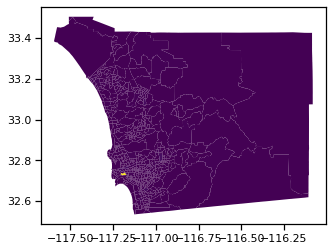

In [11]:
t = df[(df.sex == 'FEMALE') & (df.personrole == 'SUSPECT')]
t = t.groupby('tract_geoid').pk.count().to_frame('n_crimes').reset_index().rename(columns={'tract_geoid':'geoid'})
t = tracts.merge(t, on='geoid').merge(pop, on='geoid')
t['crimes_per_pop'] = (t['n_crimes']  / t['total_population']).replace({np.inf:np.nan}).fillna(0)
t['cpp_z'] = (t.crimes_per_pop-np.mean(t.crimes_per_pop))/np.std(t.crimes_per_pop)
t.to_csv('crimes.csv')
t.plot(column='cpp_z')

In [15]:
t =df.groupby('personrole').census_race.value_counts().unstack().T
t.SUSPECT/(t.SUSPECT+t.VICTIM)

census_race
asian      0.312839
black      0.649256
hisp       0.464926
nhopi      0.501545
nhwhite    0.375976
other      0.112949
unknown    0.999904
white      0.336891
dtype: float64

In [65]:
b02001 = fetch(f'census://2018/5/CA/tract/B02001') # B02001: Race

ra = b02001.rename(columns={'b02001_002':'white_alone', 'b02001_003':'black_alone','b02001_005':'asian_alone'})\
    [['white_alone','black_alone','asian_alone']]

b03002 = fetch(f'census://2018/5/CA/tract/B03002') # Hispanic status
b02009 = fetch(f'census://2018/5/CA/tract/B02009') # black alone, or in combination with 1 or more other races
b02008 = fetch(f'census://2018/5/CA/tract/B02008') # white alone, or in combination with 1 or more other races
b02011 = fetch(f'census://2018/5/CA/tract/B02011') # asian alone, or in combination with 1 or more other races
b01003 = fetch(f'census://2018/5/CA/tract/B01003') # total population 

t = b03002[['b03002_003','b03002_012']].rename(columns={'b03002_003':'nhwhite', 'b03002_012':'hisp'})\
    .join(b02008[['b02008_001']].rename(columns={'b02008_001':'white'}))\
    .join(b02009[['b02009_001']].rename(columns={'b02009_001':'black'}))\
    .join(b02011[['b02011_001']].rename(columns={'b02011_001':'asian'}))\
    .join(ra)\
    .join(b01003[['b01003_001']].rename(columns={'b01003_001':'total_pop'}))
    
race_pop = t.join(t.iloc[:,[5,6,7]].sum(axis=1).to_frame('alone_sum'))
race_pop.head()


,nhwhite,hisp,white,black,asian,white_alone,black_alone,asian_alone,total_pop,alone_sum
geoid,,,,,,,,,,
14000US06001400100,2055,104,2258,163,723,2122,128,599,3115,2849
14000US06001400200,1436,178,1754,101,320,1551,59,183,2025,1793
14000US06001400300,3458,364,3961,494,625,3757,380,535,5000,4672
14000US06001400400,2551,420,3001,309,582,2703,229,373,3843,3305
14000US06001400500,1885,334,2386,1069,461,2036,990,264,3786,3290


In [117]:
aland = rg.geoframe(f'censusgeo://2018/5/CA/tract')[['geoid','aland','geometry']].set_index('geoid')
aland

,aland,geometry
geoid,,
14000US06037137504,3837562,"POLYGON ((-118.58119 34.14318, -118.58099 34.1..."
14000US06037138000,4472196,"POLYGON ((-118.60573 34.14585, -118.60561 34.1..."
14000US06037139200,1152031,"POLYGON ((-118.53082 34.18024, -118.52952 34.1..."
14000US06067002300,1213095,"POLYGON ((-121.50218 38.55643, -121.50184 38.5..."
14000US06067002400,3224718,"POLYGON ((-121.50970 38.54070, -121.50960 38.5..."
...,...,...
14000US06059001303,1179651,"POLYGON ((-117.95917 33.92458, -117.95888 33.9..."
14000US06059001304,1252716,"POLYGON ((-117.95918 33.92820, -117.95831 33.9..."
14000US06059001401,1592982,"POLYGON ((-117.95056 33.94503, -117.95055 33.9..."


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             crime_rate   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     26.85
Date:                Sat, 17 Oct 2020   Prob (F-statistic):           2.44e-16
Time:                        17:08:43   Log-Likelihood:                 1140.1
No. Observations:                 625   AIC:                            -2272.
Df Residuals:                     621   BIC:                            -2254.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0313      0.012     -2.615      0.009      -0.055      -0.008
white_rate      0.0618      0.014      4.456      0.000       0.035       0.089
bh_rate         0.0933      0.013      6.917      0.000       0.067       0.120
pop_density     2.0720      0.744      2.783      0.006       0.610       3.534
==============================================================================
Omnibus:                      605.770   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20890.374
Skew:                           4.427   Prob(JB):                         0.00
Kurtosis:                      29.903   Cond. No.                         559.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

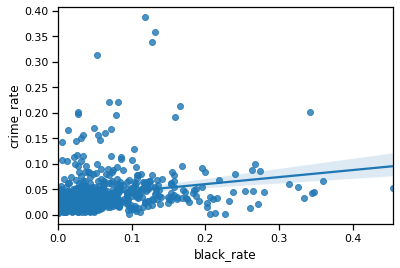

In [196]:
# UCR codes 
# 1xx homicide
# 2xx rape
# 3xx robbery
# 4xxx assault, battery
# 5xx theft burglary
# 6xx theft burglary
# 7xx vehicles
# 8xx arson

crimes = ui[ui.codeucr.str[0].isin(('1','2','3','4'))].groupby('tract_geoid').pk.count().to_frame('crimes')


t = aland.join(race_pop).join(crimes)
t = t[~t.crimes.isnull()]
t['bh'] = t.black + t.hisp
t['pop_density'] = t.total_pop/t.aland
t['black_rate'] = t.black / t.total_pop
t['white_rate'] = t.nhwhite / t.total_pop
t['hisp_rate'] = t.hisp / t.total_pop
t['bh_rate'] = t.bh / t.total_pop
t['crime_rate'] = t.crimes / t.total_pop

excl = [
    '14000US06073006200', # Convention center and airport
]

t = t[~t.index.isin(excl)]

sns.regplot(x=t.black_rate,y=t.crime_rate)

from statsmodels.formula.api import ols

m = ols("crime_rate ~ white_rate + bh_rate + pop_density", t).fit()

m.summary() 


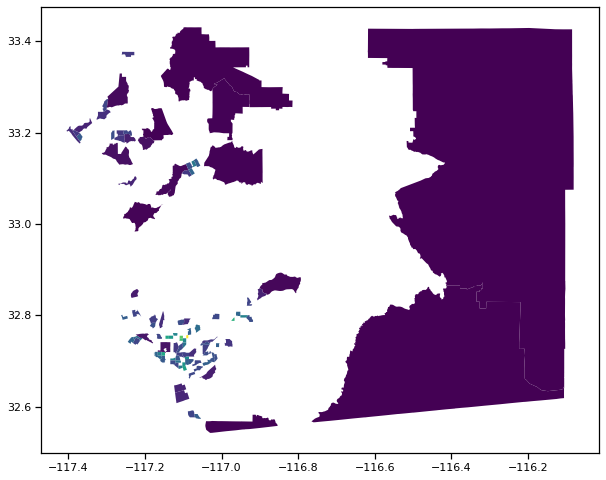

In [180]:

t.plot(ax=ax, column='pop_density')

In [200]:
df.head().T

,0,1,2,3,4
pk,12144871,12127327,12278698,12278698,12364997
activitynumber,'01600014','16000042','16005661','16005661','16008822'
activitydate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
year,2016,2016,2016,2016,2016
agency,NATIONAL CITY,SAN DIEGO,SAN DIEGO,SAN DIEGO,SAN DIEGO
violationsection,10851,459,488,488,487(A)
violationtype,VC,PC,PC,PC,PC
chargedescription,TAKE VEHICLE W/O OWNER'S CONSENT/VEHICLE THEFT,BURGLARY/UNSPECIFIED,PETTY THEFT,PETTY THEFT,GRAND THEFT:MONEY/LABOR/PROPERTY OVER $950
chargelevel,FELONY,FELONY,MISDEMEANOR,MISDEMEANOR,FELONY
codeucr,7A0,5A6,6DG,6DG,6AE


In [319]:
t = df.copy()
t['personrole'] = t.personrole.replace({'VICTIM/WITNESS':'VICTIM'})
t = t.groupby(['pk','personrole','census_race']).activitynumber.count().sort_values(ascending=False)\
    .to_frame('n').reset_index()
t = t[~t.census_race.isin(['unknown','other','nhopi', 'white'])]
t = t.sort_values(['pk','census_race','personrole']).set_index(['pk','personrole', 'census_race' ]).unstack([1,2]).fillna(0)
t.columns = [f"{race}_{role.lower()}" for n,role,race in t.columns]
t

,nhwhite_suspect,nhwhite_victim,asian_suspect,black_victim,black_suspect,hisp_victim,asian_victim,hisp_suspect
pk,,,,,,,,
9315394,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11205133,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
11629551,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12064114,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
12123003,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
18955948,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18956062,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
18956669,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [326]:
tt = t.replace({0:-1})

(tt/np.abs(tt)).corr()

,nhwhite_suspect,nhwhite_victim,asian_suspect,black_victim,black_suspect,hisp_victim,asian_victim,hisp_suspect
nhwhite_suspect,1.000000,0.109947,-0.064337,-0.079020,-0.170069,-0.170534,-0.063243,-0.222023
nhwhite_victim,0.109947,1.000000,-0.051672,-0.261930,-0.146344,-0.530650,-0.205705,-0.232817
asian_suspect,-0.064337,-0.051672,1.000000,-0.016589,-0.042882,-0.038736,0.163340,-0.059314
black_victim,-0.079020,-0.261930,-0.016589,1.000000,0.269617,-0.182241,-0.073344,-0.075964
black_suspect,-0.170069,-0.146344,-0.042882,0.269617,1.000000,-0.084865,-0.035264,-0.153466
hisp_victim,-0.170534,-0.530650,-0.038736,-0.182241,-0.084865,1.000000,-0.148529,0.249501
asian_victim,-0.063243,-0.205705,0.163340,-0.073344,-0.035264,-0.148529,1.000000,-0.069370
hisp_suspect,-0.222023,-0.232817,-0.059314,-0.075964,-0.153466,0.249501,-0.069370,1.000000


In [264]:
x[ (x.black_suspect>0) & (x.black_victim>0)].chargedescription.value_counts().head(10)

BATTERY ON PERSON (M)                                      3001
BATTERY:SPOUSE/EX SPOUSE/DATE/ETC (M)                      2962
SPOUSAL/COHABITANT ABUSE WITH MINOR INJURY (F)             2429
INFLICT CORPORAL INJURY ON SPOUSE/COHABITANT               2217
BATTERY: SPOUSE/EX SPOUSE/DATE/ETC                         1879
ASSAULT W/DEADLY WEAPON:NOT F/ARM (F)                      1346
ROBBERY (F)                                                1291
ASSAULT W/DEADLY WEAPON OTHER THAN FIREARM OR GBI FORCE    1191
SIMPLE BATTERY (M)                                         1114
BATTERY ON PERSON                                           764
Name: chargedescription, dtype: int64

In [265]:
x[ (x.nhwhite_suspect>0) & (x.nhwhite_victim>0)].chargedescription.value_counts().head(10)

BATTERY ON PERSON (M)                                 8963
BATTERY:SPOUSE/EX SPOUSE/DATE/ETC (M)                 8888
SPOUSAL/COHABITANT ABUSE WITH MINOR INJURY (F)        8180
SIMPLE BATTERY (M)                                    6777
INFLICT CORPORAL INJURY ON SPOUSE/COHABITANT          3843
ASSAULT W/DEADLY WEAPON:NOT F/ARM (F)                 3810
BURGLARY (RESIDENTIAL) (F)                            3349
BATTERY: SPOUSE/EX SPOUSE/DATE/ETC                    3291
TAKE VEHICLE W/O OWNER'S CONSENT/VEHICLE THEFT (F)    2629
ROBBERY (F)                                           2386
Name: chargedescription, dtype: int64

In [266]:
x[ (x.black_suspect>0) & (x.nhwhite_victim>0)].chargedescription.value_counts().head(10)

ROBBERY (F)                                                2650
BATTERY ON PERSON (M)                                      2411
SIMPLE BATTERY (M)                                         1517
BURGLARY (RESIDENTIAL) (F)                                 1379
ROBBERY                                                    1204
SPOUSAL/COHABITANT ABUSE WITH MINOR INJURY (F)             1086
BATTERY:SPOUSE/EX SPOUSE/DATE/ETC (M)                       986
ASSAULT W/DEADLY WEAPON:NOT F/ARM (F)                       970
INFLICT CORPORAL INJURY ON SPOUSE/COHABITANT                790
OBSTRUCT/RESIST EXECUTIVE OFFICER WITH MINOR INJURY (F)     738
Name: chargedescription, dtype: int64

In [267]:
x[ (x.nhwhite_suspect>0) & (x.black_victim>0)].chargedescription.value_counts().head(10)

BATTERY ON PERSON (M)                                      1053
SIMPLE BATTERY (M)                                          669
BATTERY:SPOUSE/EX SPOUSE/DATE/ETC (M)                       559
ASSAULT W/DEADLY WEAPON:NOT F/ARM (F)                       538
ROBBERY (F)                                                 453
ASSAULT W/DEADLY WEAPON OTHER THAN FIREARM OR GBI FORCE     333
SPOUSAL/COHABITANT ABUSE WITH MINOR INJURY (F)              302
TAKE VEHICLE W/O OWNER'S CONSENT/VEHICLE THEFT (F)          291
BATTERY ON PERSON                                           285
BATTERY: SPOUSE/EX SPOUSE/DATE/ETC                          262
Name: chargedescription, dtype: int64

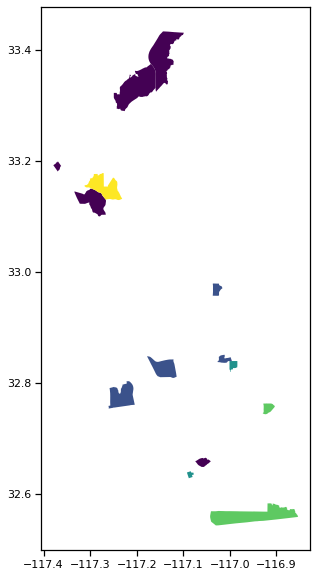

In [318]:
chorocol = 'victim'

cc = df.groupby(['tract_geoid','pk', 'personrole']).activitynumber.count().to_frame('pr_count').unstack().fillna(0)
cc = cc.reset_index()
cc.columns = ['geoid','pk','suspect','victim','witness']
cc = cc[cc[chorocol]> 25]
cc = cc.sort_values([chorocol], ascending=False).groupby('geoid').first()


fig, ax = plt.subplots(1, figsize=(10,10))
tracts.reset_index().merge(cc, on='geoid').plot(column=chorocol, ax=ax, scheme='fisher_jenks')

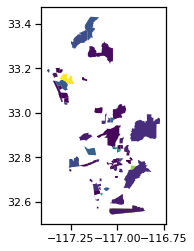